In [1]:
import numpy as np
from qiskit import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.visualization import plot_histogram
from random import randint

In [2]:
I = np.identity(8)
print(I)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [17]:
c = QuantumCircuit(3,3)
c.h(range(3))
c.barrier()

#a = randint(0,2)
#b = (a+1)%3
#c = (a+2)%3
#c.h(0)
#c.ccx(1,2,0)
#c.h(0)

Grov = Operator([[1,0,0,0,0,0,0],
                [0,1,0,0,0,0,0,0],
                [0,0,1,0,0,0,0,0],
                [0,0,0,1,0,0,0,0],
                [0,0,0,0,1,0,0,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,-1]])
c.append(Grov,[0,1,2])
c.barrier()

TypeError: must be real number, not list

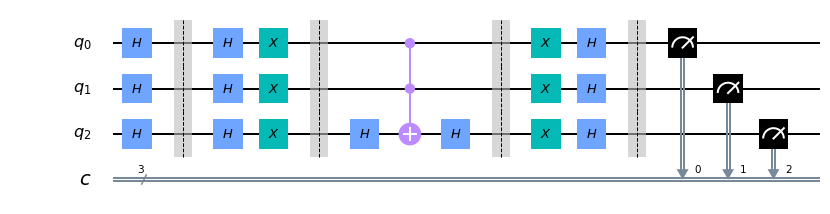

In [18]:
c.h(range(3))
c.x(range(3))
c.barrier()
c.h(2)
c.ccx(0,1,2)
c.h(2)
c.barrier()
c.x(range(3))
c.h(range(3))
c.barrier()

c.measure([0,1,2],[0,1,2])

c.draw(output='mpl')

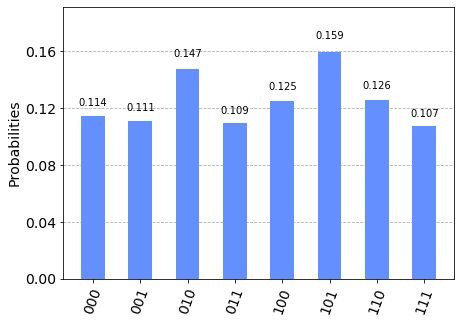

In [19]:
#simulate on qiskit aer
sim = Aer.get_backend('qasm_simulator')
sres = execute(c, backend = sim, shots = 1024).result()

#writing something to plot the simulation results on a histogram
plot_histogram(sres.get_counts(c))

In [20]:
#running on a real quantum device
from qiskit.providers.aqt import AQT
aqt_provider_simulators = AQT.enable_account('2633b2d14dae4d9da7c9df2503857334')
provider = IBMQ.load_account()  
qcomp = provider.get_backend('ibmq_16_melbourne')
job = execute(c, backend = qcomp, shots = 1024)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


In [11]:
#plotting the results of the real computation
qres = job.result()
counts = qres.get_counts()
print('The run counts are:', counts)
plot_histogram([qres.get_counts(c), sres.get_counts(c)], legend=['Device', 'Simulator'])

NameError: name 'job' is not defined

In [ ]:
#noise mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

cal_circuits, state_labels = complete_meas_cal(qr = c.qregs[0], circlabel = 'measerrormitcal')
cal_job = execute(cal_circuits,
                 backend = qcomp,
                 shots = 1024,
                 optimization_level = 0,
                 )

#this part runs the predefined calibration circuits for the circuit size and monitors the job
job_monitor(cal_job)
calres = cal_job.result()

#we use the calibration result to filter out our noisy results
meas_fitter = CompleteMeasFitter(calres, state_labels)

#filtering out noise from the quantum result
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
mitres = meas_filter.apply(qres)

In [ ]:
#plotting the sim vs noisy results vs mitigated results
qcounts = qres.get_counts(c)
mitcounts = mitres.get_counts(c)
plot_histogram([counts, qcounts, mitcounts], legend = ['sim', 'noisy results', 'mitigated results'])